#  Defend against augmentation attacks in face recognition models

In [1]:
%pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.5 MB/s eta 0:00:00


In [2]:
'''General packages'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import cv2
from PIL import Image
import os
import time
from tqdm import *

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import glob
from datetime import datetime
import argparse
from facenet_pytorch import InceptionResnetV1

torch.manual_seed(42)


In [3]:
! git clone https://github.com/shellyfra/Defend_against_attribute_attacks_in_face_recognition_models.git

Cloning into 'Defend_against_attribute_attacks_in_face_recognition_models'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 304 (delta 4), reused 6 (delta 2), pack-reused 294
Receiving objects: 100% (304/304), 21.03 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [4]:
from Defend_against_attribute_attacks_in_face_recognition_models.utils import train, imshow_no_normalization, set_parameter_requires_grad, get_params_to_update, eval_acc, imshow

In [5]:
%cd Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes

/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes


## Helper functions

In [6]:
# install our pre-trained models on celebA-HQ dataset (with / without augmentation and with attributes)
!bash download.sh models-weights

--2023-01-22 11:17:03--  https://docs.google.com/uc?export=download&confirm=t&id=1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_
Resolving docs.google.com (docs.google.com)... 108.177.119.102, 108.177.119.100, 108.177.119.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mr331ei42f9ap9i44gp4qr28qm1as7qh/1674386175000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=63288609-fe3f-44a7-ab0f-34d577785981 [following]
--2023-01-22 11:17:03--  https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mr331ei42f9ap9i44gp4qr28qm1as7qh/1674386175000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=63288609-fe3f-44a7-ab0f-34d577785981
Resolving doc-14-08-docs.googleusercontent.com (doc-14-08-docs.googleusercontent.com)... 108.177.119.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
parser = argparse.ArgumentParser()
parser.add_argument('model_path', type=str, default=r'/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', help='the path to save model weights after training')
parser.add_argument('image_size', type=int, default=256, help='the image size to enter the face recognition model') # 256 is the size for FaceNet
parser.add_argument('lr', type=float, default=0.018886927287921115, help='the learning rate used for train on CelebA data') # Optuna's choice
parser.add_argument('lr_aug', type=float, default=0.000615545095147844, help='the learning rate used for train on CelebA data') # Optuna's choice
parser.add_argument('momentum', type=float, default=0.9, help='the momentum used for train on CelebA data')
parser.add_argument('train_celebA_num_epochs', type=int, default=20, help='the number of epochs used for the first train phase on CelebA data with no augmentation')
parser.add_argument('batch_size', type=int, default=64, help='train and test batch size')

parser.add_argument('num_workers', type=int, default=2, help='train and test num workers')
parser.add_argument('train_aug_celebA_num_epochs', type=int, default=5, help='the number of epochs used for the first train phase on CelebA data with no augmentation')

args = parser.parse_args(args=['/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', '256', '0.018886927287921115', '0.000615545095147844', '0.9', '20', '64', '2', '5'])
print(args)

Namespace(batch_size=64, image_size=256, lr=0.018886927287921115, lr_aug=0.000615545095147844, model_path='/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', momentum=0.9, num_workers=2, train_aug_celebA_num_epochs=5, train_celebA_num_epochs=20)


## Load the CelebA-HQ dataset

In [8]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 -O CelebA_HQ_facial_identity_dataset.zip
!unzip CelebA_HQ_facial_identity_dataset.zip -d ./CelebA_HQ_facial_identity_dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./CelebA_HQ_facial_identity_dataset/test/563/8709.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/563/9976.jpg  
   creating: ./CelebA_HQ_facial_identity_dataset/test/564/
  inflating: ./CelebA_HQ_facial_identity_dataset/test/564/6738.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/564/7152.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/564/739.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/564/7871.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/564/9481.jpg  
   creating: ./CelebA_HQ_facial_identity_dataset/test/571/
  inflating: ./CelebA_HQ_facial_identity_dataset/test/571/4864.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/571/5042.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/571/748.jpg  
  inflating: ./CelebA_HQ_facial_identity_dataset/test/571/9549.jpg  
   creating: ./CelebA_HQ_facial_identity_dataset/test/573/
  inflating: ./

## Pre-process the data

### all needed transforms :

In [13]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
        
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transforms_attack2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalization is done in dataloader
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    AddGaussianNoise(0., 0.1)
    ])

transforms_attack3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalization is done in dataloader
    transforms.ColorJitter(brightness=.1, hue=.1),
    AddGaussianNoise(0., 0.1)
    ])

transforms_orig = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])


In [14]:
data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Display few images from the dataset

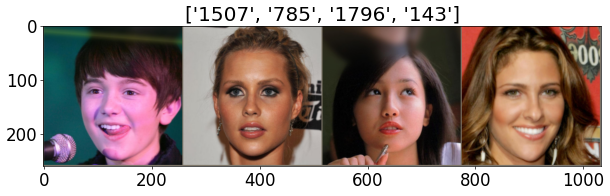

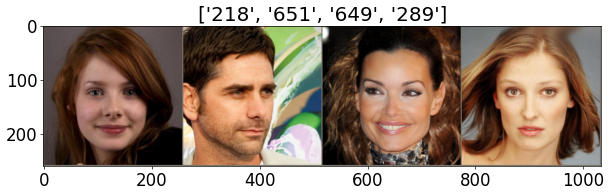

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

# load a batch of test image
iterator = iter(test_dataloader)

# visualize a batch of test image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

## Fine-Tune FaceNet on CelebA-HQ

In [ ]:
faceNet = InceptionResnetV1(pretrained='vggface2')

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# num_classes = len(identity_df.id.unique())
num_classes = len(class_names)
print(f'number of identities = {num_classes}, number of images = {len(train_dataset.imgs + test_dataset.imgs)}')

number of identities = 307, number of images = 5478


In [ ]:
faceNet = set_parameter_requires_grad(faceNet, num_classes)
# new_resnet
params_to_update = []
for name,param in faceNet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

"""
Optuna Best trial:
  Params: 
    optimizer: SGD
    lr: 0.018886927287921115
    batch_size: 64
"""
optimizer = torch.optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()

	 logits.weight
	 logits.bias


In [ ]:
train_losses, test_losses, train_acc, test_acc = train(faceNet, criterion, optimizer, args.train_celebA_num_epochs, train_dataloader, train_dataset, test_dataloader, test_dataset, args.model_path, with_aug=False)

67it [06:55,  6.20s/it]

[Train #0] Loss: 3.1785 Acc: 50.4574% Time: 417.7512s


[Test #0] Loss: 0.8345 Acc: 94.8148% Time: 527.5462s
==> Saving model ...


67it [06:48,  6.09s/it]

[Train #1] Loss: 0.4643 Acc: 97.1616% Time: 938.7433s


[Test #1] Loss: 0.3786 Acc: 96.4609% Time: 1047.6886s
==> Saving model ...


67it [06:47,  6.08s/it]

[Train #2] Loss: 0.2292 Acc: 98.8740% Time: 1458.3182s


[Test #2] Loss: 0.2854 Acc: 96.9547% Time: 1566.0538s
==> Saving model ...


67it [06:44,  6.04s/it]

[Train #3] Loss: 0.1599 Acc: 99.1086% Time: 1974.1498s


[Test #3] Loss: 0.2523 Acc: 96.9547% Time: 2082.6654s
==> Saving model ...


67it [06:45,  6.05s/it]

[Train #4] Loss: 0.1227 Acc: 99.3197% Time: 2490.9382s


[Test #4] Loss: 0.2270 Acc: 97.2016% Time: 2598.0212s
==> Saving model ...


67it [06:45,  6.05s/it]

[Train #5] Loss: 0.0999 Acc: 99.6012% Time: 3006.9443s


[Test #5] Loss: 0.2156 Acc: 97.2840% Time: 3115.6808s
==> Saving model ...


67it [06:44,  6.03s/it]

[Train #6] Loss: 0.0892 Acc: 99.5543% Time: 3523.2863s


[Test #6] Loss: 0.1997 Acc: 97.2016% Time: 3631.9163s
==> Saving model ...


67it [06:43,  6.02s/it]

[Train #7] Loss: 0.0768 Acc: 99.5543% Time: 4038.2083s


[Test #7] Loss: 0.1960 Acc: 97.3663% Time: 4146.8490s
==> Saving model ...


67it [06:41,  5.99s/it]

[Train #8] Loss: 0.0657 Acc: 99.7420% Time: 4551.8330s


[Test #8] Loss: 0.1862 Acc: 97.3663% Time: 4659.4919s
==> Saving model ...


67it [06:46,  6.07s/it]

[Train #9] Loss: 0.0581 Acc: 99.7889% Time: 5069.6847s


[Test #9] Loss: 0.1828 Acc: 97.2840% Time: 5178.6864s
==> Saving model ...


67it [06:43,  6.03s/it]

[Train #10] Loss: 0.0543 Acc: 99.8123% Time: 5585.8266s


[Test #10] Loss: 0.1784 Acc: 97.2840% Time: 5695.4389s
==> Saving model ...


67it [06:43,  6.02s/it]

[Train #11] Loss: 0.0495 Acc: 99.8593% Time: 6102.4433s


[Test #11] Loss: 0.1761 Acc: 97.0370% Time: 6210.3221s
==> Saving model ...


67it [06:42,  6.01s/it]

[Train #12] Loss: 0.0479 Acc: 99.7654% Time: 6616.3554s


[Test #12] Loss: 0.1721 Acc: 97.3663% Time: 6724.4562s
==> Saving model ...


67it [06:40,  5.98s/it]

[Train #13] Loss: 0.0465 Acc: 99.7420% Time: 7129.1620s


[Test #13] Loss: 0.1710 Acc: 97.0370% Time: 7235.3883s
==> Saving model ...


67it [06:34,  5.89s/it]

[Train #14] Loss: 0.0409 Acc: 99.8358% Time: 7633.7477s


[Test #14] Loss: 0.1676 Acc: 97.4486% Time: 7739.4110s
==> Saving model ...


67it [06:39,  5.96s/it]

[Train #15] Loss: 0.0401 Acc: 99.7654% Time: 8142.4694s


[Test #15] Loss: 0.1629 Acc: 97.2016% Time: 8250.1872s
==> Saving model ...


67it [06:42,  6.01s/it]

[Train #16] Loss: 0.0397 Acc: 99.7654% Time: 8656.8670s


[Test #16] Loss: 0.1671 Acc: 97.2016% Time: 8764.9335s
==> Saving model ...


67it [06:41,  5.99s/it]

[Train #17] Loss: 0.0376 Acc: 99.7889% Time: 9170.4174s


[Test #17] Loss: 0.1622 Acc: 97.5309% Time: 9277.9885s
==> Saving model ...


67it [06:43,  6.02s/it]

[Train #18] Loss: 0.0343 Acc: 99.8358% Time: 9685.1350s


[Test #18] Loss: 0.1604 Acc: 97.2016% Time: 9792.3399s
==> Saving model ...


67it [06:33,  5.87s/it]

[Train #19] Loss: 0.0350 Acc: 99.7654% Time: 10189.2339s


[Test #19] Loss: 0.1634 Acc: 97.2016% Time: 10295.5425s
==> Saving model ...
==> Finished Training ...


##Plot and save test and train loss + accuracy

In [ ]:
test_acc_array = np.array([t.cpu().item() for t in test_acc])
train_acc_array = np.array([t.cpu().item() for t in train_acc])
test_losses = np.array(test_losses)
train_losses = np.array(train_losses)

np.save(args.model_path + r'/models/test_acc_array.npy', test_acc_array)
np.save(args.model_path + r'/models/train_acc_array.npy', train_acc_array)
np.save(args.model_path + r'/models/test_losses.npy', test_losses)
np.save(args.model_path + r'/models/train_losses.npy', train_losses)

In [ ]:
# if nessecary
test_acc_array = np.load(args.model_path + r'/models/test_acc_array.npy')
train_acc_array = np.load(args.model_path + r'/models/train_acc_array.npy')
test_losses = np.load(args.model_path + r'/models/test_losses.npy')
train_losses = np.load(args.model_path + r'/models/train_losses.npy')

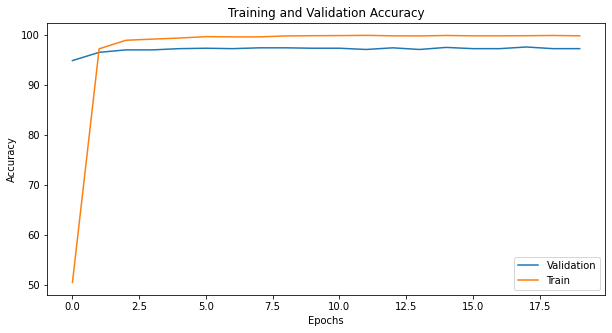

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(test_acc_array,label="Validation")
plt.plot(train_acc_array,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

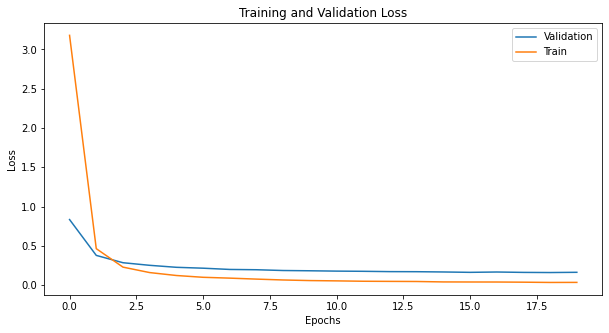

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="Validation")
plt.plot(train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Visualize evaluation on the trained FaceNet model:

In [ ]:
num_classes = len(class_names) # clebA HQ sub dataset
# print(num_classes)
celebA_facenet = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'

state = torch.load(f'{args.model_path}models/{model_name}', map_location=device)
celebA_facenet.load_state_dict(state['net'])
celebA_facenet = celebA_facenet.to(device)
celebA_facenet.classify = True
celebA_facenet.eval()

## check 1 image clasification (verify FaceNet)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


real class = 17


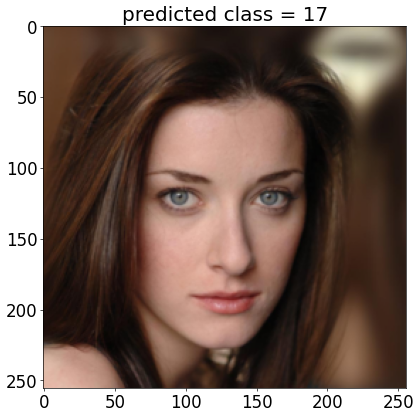

In [ ]:
iterator = iter(test_dataloader)
inputs, classes = next(iterator)
img_probs = celebA_facenet(inputs.to(device))
out2 = torchvision.utils.make_grid(inputs[0])
print(f'real class = {class_names[classes[0]]}')
imshow(out2, title=f'predicted class = {class_names[img_probs.argmax(axis=1)[0].item()]}') # title=[x for x in img_probs.argmax(axis=1)]

## Visualize the possible augmentation attack

In [ ]:
example_img_path = './CelebA_HQ_facial_identity_dataset/test/1989/7701.jpg' # ID = 1989
test_img = Image.open(example_img_path).convert('RGB')
test_img_attack2 = transforms_attack2(test_img)
test_img_attack3 = transforms_attack3(test_img)
orig_test_img = transforms_orig(test_img)

input = torch.stack([orig_test_img, test_img_attack2, test_img_attack3])

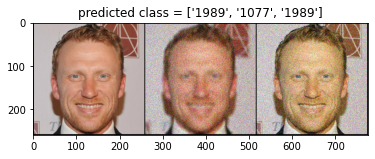

In [ ]:
img_probs = celebA_facenet(input.to(device))
out0 = torchvision.utils.make_grid(input)
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}') # title=[x for x in img_probs.argmax(axis=1)]

## Add the augmented images to the dataset

In [16]:
for filepath in glob.glob("./CelebA_HQ_facial_identity_dataset/train/*/"):
    for img_path in glob.glob(filepath + '/*'):
      test_img = Image.open(img_path).convert('RGB')
      test_img_attack2 = transforms_attack2(test_img)
      test_img_attack3 = transforms_attack3(test_img)
      torchvision.utils.save_image(test_img_attack2, img_path.split('.jpg')[0] + '_1.jpg')
      torchvision.utils.save_image(test_img_attack3,  img_path.split('.jpg')[0] + '_2.jpg')


In [17]:
for filepath in glob.glob("./CelebA_HQ_facial_identity_dataset/test/*/"):
    for img_path in glob.glob(filepath + '/*'):
      test_img = Image.open(img_path).convert('RGB')
      test_img_attack2 = transforms_attack2(test_img)
      test_img_attack3 = transforms_attack3(test_img)
      torchvision.utils.save_image(test_img_attack2, img_path.split('.jpg')[0] + '_1.jpg')
      torchvision.utils.save_image(test_img_attack3,  img_path.split('.jpg')[0] + '_2.jpg')

## check accuracy on the augmented test set

In [40]:
data_dir = './CelebA_HQ_facial_identity_dataset'
aug_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
aug_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

aug_train_dataloader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
aug_test_dataloader = torch.utils.data.DataLoader(aug_test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)


In [ ]:
print("evaluate FaceNet trained on regular data:")
eval_acc(celebA_facenet, test_dataloader, device)

print("evaluate FaceNet trained on augmented data:")
eval_acc(celebA_facenet, aug_test_dataloader, device)

evaluate FaceNet trained on regular data:
Loss: 0.1634 Acc: 97.2016% 
evaluate FaceNet trained on augmented data:
Loss: 1.2195 Acc: 73.8272% 


(1.219452249791233, tensor(73.8272, device='cuda:0'))

In [ ]:
%pwd

'/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes'

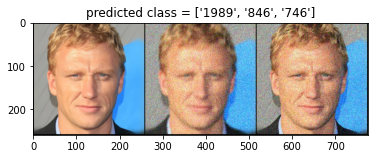

In [19]:
# visualize the identification error
example_img_path = 'CelebA_HQ_facial_identity_dataset/test/1989/' # ID = 1989

test_img = transforms_orig(Image.open(example_img_path + '9308.jpg').convert('RGB'))
test_img_attack2 = transforms_orig(Image.open(example_img_path + '9308_1.jpg').convert('RGB'))
test_img_attack3 = transforms_orig(Image.open(example_img_path + '9308_2.jpg').convert('RGB'))

input = torch.stack([test_img, test_img_attack2, test_img_attack3])
img_probs = celebA_facenet(input.to(device))
out0 = torchvision.utils.make_grid(input)
[class_names[prob.argmax().item()] for prob in img_probs]
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}')

## Retrain the fine-tuned (on CelebA) faceNet on augmented data

In [20]:
params_to_update = []
for name,param in celebA_facenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
#same optimizer and criterion
optimizer = torch.optim.SGD(params_to_update, lr=args.lr_aug, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()

	 logits.weight
	 logits.bias


In [22]:
aug_train_losses, aug_test_losses, aug_train_acc, aug_test_acc = train(celebA_facenet, criterion, optimizer, args.train_aug_celebA_num_epochs, aug_train_dataloader, aug_train_dataset, aug_test_dataloader, aug_test_dataset, args.model_path, with_aug=True, device=device)


200it [01:49,  1.83it/s]

[Train #0] Loss: 0.4470 Acc: 90.7577% Time: 109.2137s


[Test #0] Loss: 0.6348 Acc: 87.3525% Time: 139.6593s
==> Saving model ...


200it [01:48,  1.85it/s]

[Train #1] Loss: 0.4260 Acc: 91.3832% Time: 248.2946s


[Test #1] Loss: 0.6089 Acc: 87.9561% Time: 278.7427s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #2] Loss: 0.4203 Acc: 91.6256% Time: 386.7249s


[Test #2] Loss: 0.5881 Acc: 88.5322% Time: 417.2446s
==> Saving model ...


200it [01:48,  1.84it/s]

[Train #3] Loss: 0.4013 Acc: 92.1417% Time: 526.2408s


[Test #3] Loss: 0.5923 Acc: 88.2853% Time: 556.6577s
==> Saving model ...


200it [01:48,  1.84it/s]

[Train #4] Loss: 0.3945 Acc: 92.3528% Time: 665.6105s


[Test #4] Loss: 0.5867 Acc: 88.6968% Time: 695.8530s
==> Saving model ...
==> Finished Training ...


In [ ]:
aug_test_acc = np.array([t.cpu().item() for t in aug_test_acc])
aug_train_acc = np.array([t.cpu().item() for t in aug_train_acc])
aug_test_losses = np.array(aug_test_losses)
aug_train_losses = np.array(aug_train_losses)

np.save(args.model_path + r'/models/aug_test_acc.npy', aug_test_acc)
np.save(args.model_path + r'/models/aug_train_acc.npy', aug_train_acc)
np.save(args.model_path + r'/models/aug_test_losses.npy', aug_test_losses)
np.save(args.model_path + r'/models/aug_train_losses.npy', aug_train_losses)

# if nessecary
aug_test_acc = np.load(args.model_path + r'/models/aug_test_acc.npy')
aug_train_acc = np.load(args.model_path + r'/models/aug_train_acc.npy')
aug_test_losses = np.load(args.model_path + r'/models/aug_test_losses.npy')
aug_train_losses = np.load(args.model_path + r'/models/aug_train_losses.npy')

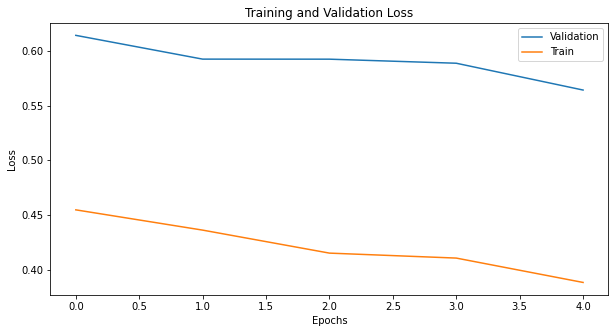

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(aug_test_losses,label="Validation")
plt.plot(aug_train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


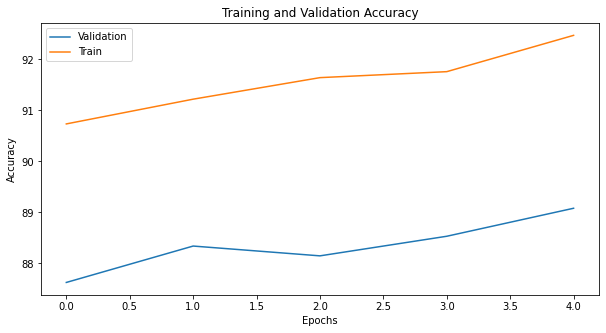

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(aug_test_acc,label="Validation")
plt.plot(aug_train_acc,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## compare old vs new (trained) network

In [24]:
celebA_facenet_old = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_old = set_parameter_requires_grad(celebA_facenet_old, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_old.load_state_dict(state['net'])
celebA_facenet_old = celebA_facenet_old.to(device)
celebA_facenet_old.eval()
celebA_facenet_old.classify = True

In [26]:
celebA_facenet_new = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_new = set_parameter_requires_grad(celebA_facenet_new, num_classes)
model_name =  'CelebA_HQ_Facenet_with_aug_fine_tune.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_new.load_state_dict(state['net'])
celebA_facenet_new = celebA_facenet_new.to(device)
celebA_facenet_new.eval()
celebA_facenet_new.classify = True

In [27]:
print("evaluate on fine-tuned not augmented data:")
eval_acc(celebA_facenet_old, aug_test_dataloader, device)

print("evaluate on fine-tuned augmented data:")
eval_acc(celebA_facenet_new, aug_test_dataloader, device)


evaluate on fine-tuned not augmented data:
Loss: 1.2103 Acc: 74.3210% 
evaluate on fine-tuned augmented data:
Loss: 0.5867 Acc: 88.6968% 


(0.586690264498746, tensor(88.6968, device='cuda:0'))

Old FaceNet:


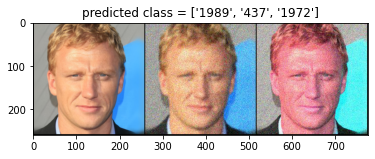

New FaceNet:


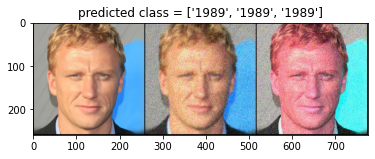

In [ ]:
# visualize the identification error
example_img_path = 'CelebA_HQ_facial_identity_dataset/test/1027/5967.jpg' # ID = 1047
example_img_path = 'CelebA_HQ_facial_identity_dataset/test/1047/5967_1.jpg' # ID = 1047

test_img = transforms_orig(Image.open('./CelebA_HQ_facial_identity_dataset/test/1989/9308.jpg').convert('RGB'))
test_img_attack2 = transforms_orig(Image.open('./CelebA_HQ_facial_identity_dataset/test/1989/9308_1.jpg').convert('RGB'))
test_img_attack3 = transforms_orig(Image.open('./CelebA_HQ_facial_identity_dataset/test/1989/9308_2.jpg').convert('RGB'))

print("Old FaceNet:")
input = torch.stack([test_img, test_img_attack2, test_img_attack3])
img_probs = celebA_facenet_old(input.to(device))
out0 = torchvision.utils.make_grid(input)
[class_names[prob.argmax().item()] for prob in img_probs]
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}')
print("New FaceNet:")
img_probs = celebA_facenet_new(input.to(device))
out0 = torchvision.utils.make_grid(input)
[class_names[prob.argmax().item()] for prob in img_probs]
imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}')

##Train the fine-tuned on CelebA FaceNet on the data augmentations

In [44]:
celebA_facenet_aug_from_scratch = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_aug_from_scratch = set_parameter_requires_grad(celebA_facenet_aug_from_scratch, num_classes).to(device)
params_to_update = []
for name,param in celebA_facenet_aug_from_scratch.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
#same optimizer and criterion
optimizer = torch.optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()


	 logits.weight
	 logits.bias


In [ ]:
print('Train dataset size:', len(aug_train_dataset))
print('Test dataset size:', len(aug_test_dataset))

In [45]:
aug_train_losses_scratch, aug_test_losses_scratch, aug_train_acc_scratch, aug_test_acc_scratch = train(celebA_facenet_aug_from_scratch, criterion, optimizer, 
                                                                       args.train_celebA_num_epochs, aug_train_dataloader, aug_train_dataset, aug_test_dataloader,
                                                                        aug_test_dataset, args.model_path, with_aug=True, free_text='scratch', device=device)

200it [01:49,  1.83it/s]

[Train #0] Loss: 1.9131 Acc: 69.2861% Time: 109.2531s


[Test #0] Loss: 0.6844 Acc: 89.8491% Time: 139.9831s
==> Saving model ...


200it [01:48,  1.84it/s]

[Train #1] Loss: 0.4336 Acc: 93.4006% Time: 248.8658s


[Test #1] Loss: 0.5404 Acc: 90.5899% Time: 279.2929s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #2] Loss: 0.3068 Acc: 95.2068% Time: 387.3539s


[Test #2] Loss: 0.4825 Acc: 90.8916% Time: 417.9069s
==> Saving model ...


200it [01:47,  1.87it/s]

[Train #3] Loss: 0.2563 Acc: 95.3476% Time: 525.4481s


[Test #3] Loss: 0.4658 Acc: 90.9191% Time: 556.1373s
==> Saving model ...


200it [01:48,  1.84it/s]

[Train #4] Loss: 0.2224 Acc: 96.0278% Time: 665.0261s


[Test #4] Loss: 0.4513 Acc: 91.0837% Time: 695.9262s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #5] Loss: 0.1919 Acc: 96.7316% Time: 804.0726s


[Test #5] Loss: 0.4584 Acc: 90.5075% Time: 834.5262s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #6] Loss: 0.1813 Acc: 96.7081% Time: 942.5584s


[Test #6] Loss: 0.4408 Acc: 90.6721% Time: 974.2297s
==> Saving model ...


200it [01:52,  1.77it/s]

[Train #7] Loss: 0.1690 Acc: 96.9192% Time: 1087.5838s


[Test #7] Loss: 0.4459 Acc: 90.3704% Time: 1117.7812s
==> Saving model ...


200it [01:50,  1.80it/s]

[Train #8] Loss: 0.1598 Acc: 97.0678% Time: 1229.0952s


[Test #8] Loss: 0.4469 Acc: 90.6173% Time: 1259.5184s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #9] Loss: 0.1573 Acc: 96.7316% Time: 1367.3796s


[Test #9] Loss: 0.4589 Acc: 90.3704% Time: 1397.9724s
==> Saving model ...


200it [01:48,  1.85it/s]

[Train #10] Loss: 0.1448 Acc: 97.2242% Time: 1506.3750s


[Test #10] Loss: 0.4460 Acc: 90.4801% Time: 1536.8738s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #11] Loss: 0.1421 Acc: 97.2164% Time: 1644.9166s


[Test #11] Loss: 0.4398 Acc: 90.2881% Time: 1675.0689s
==> Saving model ...


200it [01:47,  1.85it/s]

[Train #12] Loss: 0.1346 Acc: 97.2867% Time: 1783.2756s


[Test #12] Loss: 0.4531 Acc: 90.4527% Time: 1813.7559s
==> Saving model ...


200it [01:48,  1.85it/s]

[Train #13] Loss: 0.1262 Acc: 97.4744% Time: 1922.2632s


[Test #13] Loss: 0.4594 Acc: 90.2881% Time: 1952.5595s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #14] Loss: 0.1327 Acc: 97.2633% Time: 2060.3808s


[Test #14] Loss: 0.4532 Acc: 90.3429% Time: 2090.7518s
==> Saving model ...


200it [01:47,  1.87it/s]

[Train #15] Loss: 0.1221 Acc: 97.5369% Time: 2198.2509s


[Test #15] Loss: 0.4616 Acc: 89.8765% Time: 2228.9431s
==> Saving model ...


200it [01:47,  1.85it/s]

[Train #16] Loss: 0.1189 Acc: 97.6386% Time: 2337.1078s


[Test #16] Loss: 0.4436 Acc: 90.2332% Time: 2367.4732s
==> Saving model ...


200it [01:49,  1.83it/s]

[Train #17] Loss: 0.1143 Acc: 97.6308% Time: 2477.0402s


[Test #17] Loss: 0.4438 Acc: 90.2332% Time: 2507.9360s
==> Saving model ...


200it [01:49,  1.83it/s]

[Train #18] Loss: 0.1112 Acc: 97.6699% Time: 2617.4786s


[Test #18] Loss: 0.4546 Acc: 90.0960% Time: 2648.1907s
==> Saving model ...


200it [01:47,  1.86it/s]

[Train #19] Loss: 0.1092 Acc: 97.8263% Time: 2756.2869s


[Test #19] Loss: 0.4516 Acc: 90.5350% Time: 2786.8991s
==> Saving model ...
==> Finished Training ...


In [46]:
# save the train / test accuracy and loss - for later usage 
aug_test_acc_scratch = np.array([t.cpu().item() for t in aug_test_acc_scratch])
aug_train_acc_scratch = np.array([t.cpu().item() for t in aug_train_acc_scratch])
aug_test_losses_scratch = np.array(aug_test_losses_scratch)
aug_train_losses_scratch = np.array(aug_train_losses_scratch)

np.save(args.model_path + r'/models/aug_test_acc_scratch.npy', aug_test_acc_scratch)
np.save(args.model_path + r'/models/aug_train_acc_scratch.npy', aug_train_acc_scratch)
np.save(args.model_path + r'/models/aug_test_losses_scratch.npy', aug_test_losses_scratch)
np.save(args.model_path + r'/models/aug_train_losses_scratch.npy', aug_train_losses_scratch)

# if nessecary
aug_test_acc_scratch = np.load(args.model_path + r'/models/aug_test_acc_scratch.npy')
aug_train_acc_scratch = np.load(args.model_path + r'/models/aug_train_acc_scratch.npy')
aug_test_losses_scratch = np.load(args.model_path + r'/models/aug_test_losses_scratch.npy')
aug_train_losses_scratch = np.load(args.model_path + r'/models/aug_train_losses_scratch.npy')

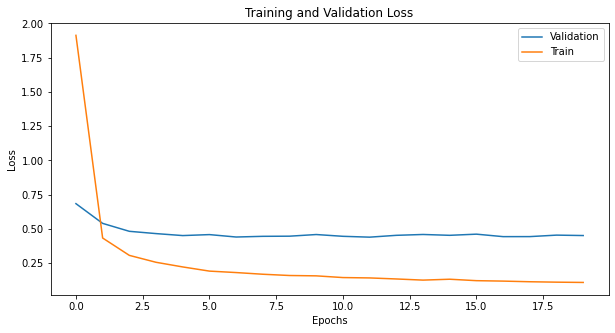

In [47]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(aug_test_losses_scratch,label="Validation")
plt.plot(aug_train_losses_scratch,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


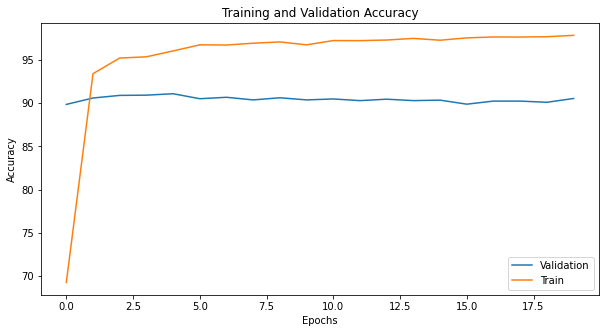

In [48]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(aug_test_acc_scratch,label="Validation")
plt.plot(aug_train_acc_scratch,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [49]:
from facenet_pytorch import MTCNN, InceptionResnetV1
celebA_facenet_scratch = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_scratch = set_parameter_requires_grad(celebA_facenet_scratch, num_classes)

model_name = 'CelebA_HQ_Facenet_with_aug_scratch.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_scratch.load_state_dict(state['net'])
celebA_facenet_scratch = celebA_facenet_scratch.to(device)

In [50]:
print("evaluate on fine-tuned not augmented data:")
eval_acc(celebA_facenet_old, aug_test_dataloader, device)

print("evaluate on fine-tuned  CelebA  + fine-tuned augmented data:")
eval_acc(celebA_facenet_new, aug_test_dataloader, device)

print("evaluate on fine-tuned augmented data from scratch:")
eval_acc(celebA_facenet_scratch, aug_test_dataloader, device)

evaluate on fine-tuned not augmented data:
Loss: 1.2103 Acc: 74.3210% 
evaluate on fine-tuned  CelebA  + fine-tuned augmented data:
Loss: 0.5867 Acc: 88.6968% 
evaluate on fine-tuned augmented data from scratch:
Loss: 0.4516 Acc: 90.5350% 


(0.45160783740228094, tensor(90.5350, device='cuda:0'))